<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [20]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [21]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="5",
                             total_timesteps=3000000)

load
Logging to ppo/5_1
-------------------------------------
| time/              |              |
|    fps             | 110          |
|    iterations      | 1            |
|    time_elapsed    | 18           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.059983414 |
-------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2           |
|    time_elapsed         | 37          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018301593 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00213    |
|    learning_rate        | 0.00025     |
|    loss                 | 8.73        |
|    n_updates            | 10          |
|   

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 12          |
|    time_elapsed         | 230         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023365658 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.8       |
|    explained_variance   | -0.00218    |
|    learning_rate        | 0.00025     |
|    loss                 | 35.3        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0169     |
|    reward               | -0.7892984  |
|    std                  | 1.02        |
|    value_loss           | 66.4        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 4199984.40
total_reward: 3199984.40
total_cost: 310594.36
total_trades: 77900
Sharpe: 0.69

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 22          |
|    time_elapsed         | 425         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.014551893 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42         |
|    explained_variance   | -0.0111     |
|    learning_rate        | 0.00025     |
|    loss                 | 65.1        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0134     |
|    reward               | 4.0272512   |
|    std                  | 1.03        |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 32          |
|    time_elapsed         | 618         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.037976347 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.4       |
|    explained_variance   | 0.0255      |
|    learning_rate        | 0.00025     |
|    loss                 | 60.7        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0146     |
|    reward               | -1.1369996  |
|    std                  | 1.05        |
|    value_loss           | 87.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 42          |
|    time_elapsed         | 809         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.020818733 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | -0.0225     |
|    learning_rate        | 0.00025     |
|    loss                 | 156         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00587    |
|    reward               | -0.35759535 |
|    std                  | 1.07        |
|    value_loss           | 283         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 43    

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 52         |
|    time_elapsed         | 1001       |
|    total_timesteps      | 106496     |
| train/                  |            |
|    approx_kl            | 0.04031747 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.4      |
|    explained_variance   | 0.0234     |
|    learning_rate        | 0.00025    |
|    loss                 | 49.8       |
|    n_updates            | 510        |
|    policy_gradient_loss | -0.0117    |
|    reward               | -3.7632308 |
|    std                  | 1.08       |
|    value_loss           | 106        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 53          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 62          |
|    time_elapsed         | 1193        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.043265514 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.0882      |
|    learning_rate        | 0.00025     |
|    loss                 | 49.1        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00587    |
|    reward               | 2.8164198   |
|    std                  | 1.1         |
|    value_loss           | 98.2        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 63       

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 72          |
|    time_elapsed         | 1386        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.052877415 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0241      |
|    learning_rate        | 0.00025     |
|    loss                 | 89.9        |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00498     |
|    reward               | -15.832735  |
|    std                  | 1.12        |
|    value_loss           | 75.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 73       

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 82          |
|    time_elapsed         | 1577        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.029681893 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45         |
|    explained_variance   | 0.308       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.1        |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00094     |
|    reward               | -0.15891089 |
|    std                  | 1.14        |
|    value_loss           | 70.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 83    

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 92          |
|    time_elapsed         | 1769        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.020246068 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.4       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.9        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00499    |
|    reward               | -2.5284863  |
|    std                  | 1.16        |
|    value_loss           | 80          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 93       

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 102         |
|    time_elapsed         | 1961        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.019819971 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.8       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00771    |
|    reward               | -1.2530526  |
|    std                  | 1.18        |
|    value_loss           | 59.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 3059542.85
total_reward: 2059542.85
total_cost: 197189.40
total_trades: 68988
Sharpe: 0.683
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 112         |
|    time_elapsed         | 2152        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.016837439 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.1       |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.4        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00507    |
|    reward               | -0.8977838  |
|    std                  | 1.19        |
|    value_loss           | 36.2        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 122         |
|    time_elapsed         | 2345        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.030633833 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.3       |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.00025     |
|    loss                 | 15          |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.0109     |
|    reward               | 0.37360168  |
|    std                  | 1.2         |
|    value_loss           | 35.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 123   

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 132        |
|    time_elapsed         | 2537       |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.04309602 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -46.8      |
|    explained_variance   | 0.265      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.92       |
|    n_updates            | 1310       |
|    policy_gradient_loss | 0.00467    |
|    reward               | 1.1335958  |
|    std                  | 1.22       |
|    value_loss           | 16.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 133         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 142         |
|    time_elapsed         | 2728        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.037887983 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.3       |
|    explained_variance   | -0.0776     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.58        |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.0015     |
|    reward               | -0.75997096 |
|    std                  | 1.24        |
|    value_loss           | 22.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 143      

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 152        |
|    time_elapsed         | 2924       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.04399655 |
|    clip_fraction        | 0.442      |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.9      |
|    explained_variance   | 0.128      |
|    learning_rate        | 0.00025    |
|    loss                 | 11.3       |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.0036    |
|    reward               | -2.912994  |
|    std                  | 1.26       |
|    value_loss           | 23.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 153         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 162        |
|    time_elapsed         | 3126       |
|    total_timesteps      | 331776     |
| train/                  |            |
|    approx_kl            | 0.04805166 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.3      |
|    explained_variance   | 0.179      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.1       |
|    n_updates            | 1610       |
|    policy_gradient_loss | -0.00995   |
|    reward               | -1.1114899 |
|    std                  | 1.28       |
|    value_loss           | 42         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 163         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 172         |
|    time_elapsed         | 3324        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.023709776 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.7       |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.9        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00689    |
|    reward               | 2.143647    |
|    std                  | 1.3         |
|    value_loss           | 83.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 182         |
|    time_elapsed         | 3517        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.049770027 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.2       |
|    explained_variance   | 0.0437      |
|    learning_rate        | 0.00025     |
|    loss                 | 62.2        |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.00329     |
|    reward               | -2.1442087  |
|    std                  | 1.32        |
|    value_loss           | 118         |
-----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 2933100.53
total_reward: 1933100.53
total_cost: 315383.74
total_trades: 72329
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 192         |
|    time_elapsed         | 3713        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.024013188 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.5       |
|    explained_variance   | 0.15        |
|    learning_rate        | 0.00025     |
|    loss                 | 114         |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00173    |
|    reward               | -5.282163   |
|    std                  | 1.34        |
|    value_loss           | 124         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 202         |
|    time_elapsed         | 3905        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.019584212 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50         |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.5        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00707    |
|    reward               | -11.779807  |
|    std                  | 1.36        |
|    value_loss           | 45.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 212         |
|    time_elapsed         | 4101        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.02942833  |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.5       |
|    explained_variance   | 0.0527      |
|    learning_rate        | 0.00025     |
|    loss                 | 83.6        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.0095     |
|    reward               | 0.051082093 |
|    std                  | 1.38        |
|    value_loss           | 119         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 213   

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 222        |
|    time_elapsed         | 4299       |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.03162486 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -50.8      |
|    explained_variance   | 0.000741   |
|    learning_rate        | 0.00025    |
|    loss                 | 63.4       |
|    n_updates            | 2210       |
|    policy_gradient_loss | -0.00915   |
|    reward               | 0.21759504 |
|    std                  | 1.4        |
|    value_loss           | 89.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 223         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 232        |
|    time_elapsed         | 4498       |
|    total_timesteps      | 475136     |
| train/                  |            |
|    approx_kl            | 0.02508067 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -51.3      |
|    explained_variance   | 0.0371     |
|    learning_rate        | 0.00025    |
|    loss                 | 58.4       |
|    n_updates            | 2310       |
|    policy_gradient_loss | -0.0112    |
|    reward               | -2.03616   |
|    std                  | 1.42       |
|    value_loss           | 113        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 233         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 242         |
|    time_elapsed         | 4694        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.019946113 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.7       |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.2        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00736    |
|    reward               | 0.5667451   |
|    std                  | 1.44        |
|    value_loss           | 67.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 243   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 252          |
|    time_elapsed         | 4894         |
|    total_timesteps      | 516096       |
| train/                  |              |
|    approx_kl            | 0.037507832  |
|    clip_fraction        | 0.253        |
|    clip_range           | 0.2          |
|    entropy_loss         | -52.3        |
|    explained_variance   | 0.325        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.64         |
|    n_updates            | 2510         |
|    policy_gradient_loss | -0.00484     |
|    reward               | -0.034673247 |
|    std                  | 1.47         |
|    value_loss           | 10.4         |
------------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 3003501.86
total_reward: 2003501.86
total_cost: 254520.01
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 262         |
|    time_elapsed         | 5096        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.025864692 |
|    clip_fraction        | 0.298       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.9       |
|    explained_variance   | -0.0519     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.88        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.0104     |
|    reward               | 0.36619893  |
|    std                  | 1.51        |
|    value_loss           | 13.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 263   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 272          |
|    time_elapsed         | 5294         |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.03936661   |
|    clip_fraction        | 0.301        |
|    clip_range           | 0.2          |
|    entropy_loss         | -53.4        |
|    explained_variance   | 0.0286       |
|    learning_rate        | 0.00025      |
|    loss                 | 10.3         |
|    n_updates            | 2710         |
|    policy_gradient_loss | 0.000415     |
|    reward               | -0.014718809 |
|    std                  | 1.53         |
|    value_loss           | 26.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 2791515.22
total_reward: 1791515.22
total_cost: 306506.93
total_trades: 73143
Sharpe: 0.659
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 282         |
|    time_elapsed         | 5497        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.026638383 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.9       |
|    explained_variance   | -0.0106     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.63        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.00999    |
|    reward               | -1.033818   |
|    std                  | 1.56        |
|    value_loss           | 19.4        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 292         |
|    time_elapsed         | 5694        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.028170157 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.5       |
|    explained_variance   | 0.0441      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.5        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.00535    |
|    reward               | -0.38039088 |
|    std                  | 1.59        |
|    value_loss           | 54.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 293   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 302         |
|    time_elapsed         | 5891        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.023741122 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.1       |
|    explained_variance   | 0.0477      |
|    learning_rate        | 0.00025     |
|    loss                 | 32.2        |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.00834    |
|    reward               | -7.706331   |
|    std                  | 1.62        |
|    value_loss           | 87.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 312         |
|    time_elapsed         | 6097        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.019130003 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.5       |
|    explained_variance   | 0.141       |
|    learning_rate        | 0.00025     |
|    loss                 | 67          |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00709    |
|    reward               | -1.4456984  |
|    std                  | 1.64        |
|    value_loss           | 171         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 322         |
|    time_elapsed         | 6302        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.029040443 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.0552      |
|    learning_rate        | 0.00025     |
|    loss                 | 44.4        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00758    |
|    reward               | -1.0568632  |
|    std                  | 1.68        |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 323   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 332         |
|    time_elapsed         | 6501        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.02457885  |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.6       |
|    explained_variance   | 0.328       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.6        |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.00362    |
|    reward               | -0.32951966 |
|    std                  | 1.71        |
|    value_loss           | 39.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 333   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 342         |
|    time_elapsed         | 6697        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.021575835 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.1       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00892    |
|    reward               | 0.62054604  |
|    std                  | 1.74        |
|    value_loss           | 37.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 4241992.99
total_reward: 3241992.99
total_cost: 274052.88
total_trades: 68975
Sharpe: 0.819
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 352        |
|    time_elapsed         | 6892       |
|    total_timesteps      | 720896     |
| train/                  |            |
|    approx_kl            | 0.02046702 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.7      |
|    explained_variance   | 0.187      |
|    learning_rate        | 0.00025    |
|    loss                 | 46.9       |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.00929   |
|    reward               | -1.4565525 |
|    std                  | 1.77       |
|    value_loss           | 75.2       |
----------------------------------------
-----------------

----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 362        |
|    time_elapsed         | 7093       |
|    total_timesteps      | 741376     |
| train/                  |            |
|    approx_kl            | 0.02069012 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.1      |
|    explained_variance   | 0.126      |
|    learning_rate        | 0.00025    |
|    loss                 | 22.8       |
|    n_updates            | 3610       |
|    policy_gradient_loss | -0.0115    |
|    reward               | 0.76960593 |
|    std                  | 1.8        |
|    value_loss           | 46.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 363         |
|    time_el

---------------------------------------
| time/                   |           |
|    fps                  | 104       |
|    iterations           | 372       |
|    time_elapsed         | 7287      |
|    total_timesteps      | 761856    |
| train/                  |           |
|    approx_kl            | 0.0226326 |
|    clip_fraction        | 0.244     |
|    clip_range           | 0.2       |
|    entropy_loss         | -58.8     |
|    explained_variance   | 0.0782    |
|    learning_rate        | 0.00025   |
|    loss                 | 13.4      |
|    n_updates            | 3710      |
|    policy_gradient_loss | -0.0114   |
|    reward               | 1.0515609 |
|    std                  | 1.84      |
|    value_loss           | 55.1      |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 373        |
|    time_elapsed         | 7306    

----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 382        |
|    time_elapsed         | 7484       |
|    total_timesteps      | 782336     |
| train/                  |            |
|    approx_kl            | 0.03399147 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.3      |
|    explained_variance   | 0.111      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.05       |
|    n_updates            | 3810       |
|    policy_gradient_loss | -0.00459   |
|    reward               | 0.33601218 |
|    std                  | 1.87       |
|    value_loss           | 14.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 383         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 392         |
|    time_elapsed         | 7681        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.010364512 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.8       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.02        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.00708    |
|    reward               | 0.3459065   |
|    std                  | 1.9         |
|    value_loss           | 24.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 402         |
|    time_elapsed         | 7881        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.017965872 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.2       |
|    explained_variance   | 0.0173      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.00378    |
|    reward               | 0.16650872  |
|    std                  | 1.94        |
|    value_loss           | 23.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 403   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 412         |
|    time_elapsed         | 8082        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.015025065 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.5       |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.3        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00599    |
|    reward               | -0.3746406  |
|    std                  | 1.96        |
|    value_loss           | 37.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 422         |
|    time_elapsed         | 8280        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.017377678 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.1       |
|    explained_variance   | 0.0862      |
|    learning_rate        | 0.00025     |
|    loss                 | 39.2        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.0109     |
|    reward               | 0.99677086  |
|    std                  | 2           |
|    value_loss           | 97          |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 3512062.26
total_reward: 2512062.26
total_cost: 234858.41
total_trades: 64033
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 432         |
|    time_elapsed         | 8478        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.014678361 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.146       |
|    learning_rate        | 0.00025     |
|    loss                 | 46.9        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00949    |
|    reward               | 0.10547312  |
|    std                  | 2.02        |
|    value_loss           | 90.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 442         |
|    time_elapsed         | 8674        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.013562077 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.1       |
|    explained_variance   | 0.462       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.2        |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00505    |
|    reward               | 2.4267259   |
|    std                  | 2.06        |
|    value_loss           | 113         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 452         |
|    time_elapsed         | 8872        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.020158142 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.4       |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.6        |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00559    |
|    reward               | -13.981437  |
|    std                  | 2.09        |
|    value_loss           | 141         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 462         |
|    time_elapsed         | 9072        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.017718505 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.9       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.9        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.0056     |
|    reward               | 0.037199117 |
|    std                  | 2.12        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 472         |
|    time_elapsed         | 9279        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.012614    |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.2       |
|    explained_variance   | 0.378       |
|    learning_rate        | 0.00025     |
|    loss                 | 86          |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00905    |
|    reward               | -0.50840515 |
|    std                  | 2.15        |
|    value_loss           | 120         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 482         |
|    time_elapsed         | 9485        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.010816736 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.6       |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.1        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00841    |
|    reward               | -0.7071674  |
|    std                  | 2.18        |
|    value_loss           | 87.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 483   

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 492         |
|    time_elapsed         | 9683        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.015562655 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.3       |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.00025     |
|    loss                 | 72.5        |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.00914    |
|    reward               | 2.2293437   |
|    std                  | 2.23        |
|    value_loss           | 82.8        |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 3261784.42
total_reward: 2261784.42
total_cost: 169572.37
total_trades: 58869
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 502         |
|    time_elapsed         | 9887        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.015941653 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.7       |
|    explained_variance   | 0.0982      |
|    learning_rate        | 0.00025     |
|    loss                 | 61.3        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.0128     |
|    reward               | 0.2544304   |
|    std                  | 2.27        |
|    value_loss           | 107         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 503

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 512         |
|    time_elapsed         | 10090       |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.017497368 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.3       |
|    explained_variance   | 0.0501      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 5110        |
|    policy_gradient_loss | -0.00981    |
|    reward               | -1.0609025  |
|    std                  | 2.31        |
|    value_loss           | 30.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 4143370.59
total_reward: 3143370.59
total_cost: 227273.08
total_trades: 62452
Sharpe: 0.744
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 522         |
|    time_elapsed         | 10291       |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.022014292 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.9       |
|    explained_variance   | -0.0112     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.6        |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.0135     |
|    reward               | -0.878316   |
|    std                  | 2.36        |
|    value_loss           | 27.2        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 532         |
|    time_elapsed         | 10493       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.015436284 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.4       |
|    explained_variance   | -0.00936    |
|    learning_rate        | 0.00025     |
|    loss                 | 37.3        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.013      |
|    reward               | 0.54666865  |
|    std                  | 2.4         |
|    value_loss           | 65.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 542         |
|    time_elapsed         | 10693       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.016710024 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67         |
|    explained_variance   | 0.0906      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.6        |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.00629    |
|    reward               | 3.8609028   |
|    std                  | 2.46        |
|    value_loss           | 72.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 543      

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 552         |
|    time_elapsed         | 10891       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.014873105 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.6       |
|    explained_variance   | 0.0491      |
|    learning_rate        | 0.00025     |
|    loss                 | 68.2        |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.0126     |
|    reward               | 1.618716    |
|    std                  | 2.5         |
|    value_loss           | 85.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 553   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 562          |
|    time_elapsed         | 11090        |
|    total_timesteps      | 1150976      |
| train/                  |              |
|    approx_kl            | 0.0114818085 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    entropy_loss         | -67.9        |
|    explained_variance   | 0.474        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.1         |
|    n_updates            | 5610         |
|    policy_gradient_loss | -0.00224     |
|    reward               | -1.5231236   |
|    std                  | 2.53         |
|    value_loss           | 53.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 572         |
|    time_elapsed         | 11290       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.009085934 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.4       |
|    explained_variance   | 0.164       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.7        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00989    |
|    reward               | -2.8730304  |
|    std                  | 2.57        |
|    value_loss           | 70.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 582         |
|    time_elapsed         | 11486       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.0141515   |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -69         |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.00025     |
|    loss                 | 105         |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00665    |
|    reward               | -0.09118464 |
|    std                  | 2.63        |
|    value_loss           | 105         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 583   

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 3904328.52
total_reward: 2904328.52
total_cost: 292632.79
total_trades: 66331
Sharpe: 0.791
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 592          |
|    time_elapsed         | 11681        |
|    total_timesteps      | 1212416      |
| train/                  |              |
|    approx_kl            | 0.0143010225 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -69.4        |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.7         |
|    n_updates            | 5910         |
|    policy_gradient_loss | -0.00653     |
|    reward               | 0.09263886   |
|    std                  | 2.66         |
|    value_loss           | 84.2         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 602         |
|    time_elapsed         | 11876       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.016221974 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.7       |
|    explained_variance   | 0.101       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.6        |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.0115     |
|    reward               | 1.463075    |
|    std                  | 2.69        |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 603   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 612         |
|    time_elapsed         | 12073       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.013861102 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.1       |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.6        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.0098     |
|    reward               | 2.8132808   |
|    std                  | 2.73        |
|    value_loss           | 184         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 613   

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 622        |
|    time_elapsed         | 12269      |
|    total_timesteps      | 1273856    |
| train/                  |            |
|    approx_kl            | 0.01796044 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -70.6      |
|    explained_variance   | 0.00196    |
|    learning_rate        | 0.00025    |
|    loss                 | 34.2       |
|    n_updates            | 6210       |
|    policy_gradient_loss | -0.0159    |
|    reward               | 0.49438143 |
|    std                  | 2.78       |
|    value_loss           | 117        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 623         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 632         |
|    time_elapsed         | 12473       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.022656444 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00576    |
|    reward               | -1.1970549  |
|    std                  | 2.84        |
|    value_loss           | 21.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 633   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 642         |
|    time_elapsed         | 12671       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.026387658 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.9       |
|    explained_variance   | 0.124       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.4         |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00974    |
|    reward               | 1.5636964   |
|    std                  | 2.9         |
|    value_loss           | 17.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 643

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 652         |
|    time_elapsed         | 12870       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.022459637 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.5       |
|    explained_variance   | 0.0369      |
|    learning_rate        | 0.00025     |
|    loss                 | 12          |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.0174     |
|    reward               | 1.7438297   |
|    std                  | 2.97        |
|    value_loss           | 22.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 662         |
|    time_elapsed         | 13068       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.014940231 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.1       |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.2        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.0142     |
|    reward               | -0.33073607 |
|    std                  | 3.03        |
|    value_loss           | 37.6        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 4179608.04
total_reward: 3179608.04
total_cost: 333218.98
total_trades: 66203
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 672         |
|    time_elapsed         | 13267       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.020724744 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74         |
|    explained_variance   | 0.0193      |
|    learning_rate        | 0.00025     |
|    loss                 | 21.2        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.0147     |
|    reward               | 0.2387574   |
|    std                  | 3.13        |
|    value_loss           | 86.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 673   

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 682        |
|    time_elapsed         | 13465      |
|    total_timesteps      | 1396736    |
| train/                  |            |
|    approx_kl            | 0.01709288 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.6      |
|    explained_variance   | 0.00596    |
|    learning_rate        | 0.00025    |
|    loss                 | 50.4       |
|    n_updates            | 6810       |
|    policy_gradient_loss | -0.0183    |
|    reward               | 1.7926425  |
|    std                  | 3.19       |
|    value_loss           | 177        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 683         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 692         |
|    time_elapsed         | 13663       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.015975827 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.2       |
|    explained_variance   | 0.00586     |
|    learning_rate        | 0.00025     |
|    loss                 | 33.3        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.0118     |
|    reward               | 2.690943    |
|    std                  | 3.26        |
|    value_loss           | 133         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 693   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 702         |
|    time_elapsed         | 13862       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.017530056 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.9       |
|    explained_variance   | 0.00383     |
|    learning_rate        | 0.00025     |
|    loss                 | 86.5        |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00261    |
|    reward               | 8.439548    |
|    std                  | 3.34        |
|    value_loss           | 211         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 703   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 712         |
|    time_elapsed         | 14060       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.012853468 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.5       |
|    explained_variance   | -0.000122   |
|    learning_rate        | 0.00025     |
|    loss                 | 226         |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.0128     |
|    reward               | 0.116408244 |
|    std                  | 3.41        |
|    value_loss           | 244         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 713   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 722         |
|    time_elapsed         | 14262       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.013317141 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.00448     |
|    learning_rate        | 0.00025     |
|    loss                 | 74.5        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00679    |
|    reward               | -2.4644978  |
|    std                  | 3.49        |
|    value_loss           | 209         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 723   

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 732        |
|    time_elapsed         | 14459      |
|    total_timesteps      | 1499136    |
| train/                  |            |
|    approx_kl            | 0.02023488 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.8      |
|    explained_variance   | 0.00152    |
|    learning_rate        | 0.00025    |
|    loss                 | 63.8       |
|    n_updates            | 7310       |
|    policy_gradient_loss | -0.00814   |
|    reward               | -1.2094644 |
|    std                  | 3.56       |
|    value_loss           | 197        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 733         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 742        |
|    time_elapsed         | 14656      |
|    total_timesteps      | 1519616    |
| train/                  |            |
|    approx_kl            | 0.01884335 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.4      |
|    explained_variance   | -0.0018    |
|    learning_rate        | 0.00025    |
|    loss                 | 65.9       |
|    n_updates            | 7410       |
|    policy_gradient_loss | -0.0107    |
|    reward               | 1.1019111  |
|    std                  | 3.64       |
|    value_loss           | 138        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 743         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 752         |
|    time_elapsed         | 14853       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.014014125 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.1       |
|    explained_variance   | 0.0103      |
|    learning_rate        | 0.00025     |
|    loss                 | 46.5        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.0118     |
|    reward               | 1.369691    |
|    std                  | 3.73        |
|    value_loss           | 80.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 4206247.42
total_reward: 3206247.42
total_cost: 354523.49
total_trades: 65757
Sharpe: 0.833
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 762         |
|    time_elapsed         | 15050       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.017336402 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.7       |
|    explained_variance   | 0.0117      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.14        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.013      |
|    reward               | 2.9627285   |
|    std                  | 3.8         |
|    value_loss           | 15          |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 772         |
|    time_elapsed         | 15246       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.015945287 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.2       |
|    explained_variance   | -0.0341     |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.0134     |
|    reward               | -0.3895367  |
|    std                  | 3.87        |
|    value_loss           | 38.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 782         |
|    time_elapsed         | 15443       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.027294084 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.7       |
|    explained_variance   | -0.00874    |
|    learning_rate        | 0.00025     |
|    loss                 | 25.3        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.00706    |
|    reward               | -4.446059   |
|    std                  | 3.94        |
|    value_loss           | 62.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 783   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 792         |
|    time_elapsed         | 15641       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.017574675 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | -0.0208     |
|    learning_rate        | 0.00025     |
|    loss                 | 42.3        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.0114     |
|    reward               | 3.7946324   |
|    std                  | 4.02        |
|    value_loss           | 90.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 793   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 802         |
|    time_elapsed         | 15840       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.005116967 |
|    clip_fraction        | 0.0153      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.8       |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.00025     |
|    loss                 | 44          |
|    n_updates            | 8010        |
|    policy_gradient_loss | -0.00644    |
|    reward               | 2.2150056   |
|    std                  | 4.09        |
|    value_loss           | 171         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 803   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 812          |
|    time_elapsed         | 16039        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0025499724 |
|    clip_fraction        | 0.00244      |
|    clip_range           | 0.2          |
|    entropy_loss         | -82.2        |
|    explained_variance   | 0.328        |
|    learning_rate        | 0.00025      |
|    loss                 | 83.1         |
|    n_updates            | 8110         |
|    policy_gradient_loss | -0.00333     |
|    reward               | 4.9656467    |
|    std                  | 4.15         |
|    value_loss           | 151          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 822         |
|    time_elapsed         | 16249       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.010052932 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.8       |
|    explained_variance   | 0.053       |
|    learning_rate        | 0.00025     |
|    loss                 | 74.3        |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00846    |
|    reward               | 1.737711    |
|    std                  | 4.23        |
|    value_loss           | 184         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 823

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 832         |
|    time_elapsed         | 16448       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.013303041 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.3       |
|    explained_variance   | 0.159       |
|    learning_rate        | 0.00025     |
|    loss                 | 87.1        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.0109     |
|    reward               | -0.42851937 |
|    std                  | 4.31        |
|    value_loss           | 213         |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 3792227.34
total_reward: 2792227.34
total_cost: 271806.23
total_trades: 63196
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 842         |
|    time_elapsed         | 16646       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.008888511 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84         |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.00025     |
|    loss                 | 130         |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.0102     |
|    reward               | -1.5136712  |
|    std                  | 4.42        |
|    value_loss           | 216         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 843   

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 852        |
|    time_elapsed         | 16844      |
|    total_timesteps      | 1744896    |
| train/                  |            |
|    approx_kl            | 0.01589441 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -84.7      |
|    explained_variance   | 0.333      |
|    learning_rate        | 0.00025    |
|    loss                 | 84.7       |
|    n_updates            | 8510       |
|    policy_gradient_loss | -0.0102    |
|    reward               | -1.795022  |
|    std                  | 4.52       |
|    value_loss           | 200        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 853         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 862         |
|    time_elapsed         | 17042       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.012043778 |
|    clip_fraction        | 0.0991      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.3       |
|    explained_variance   | 0.00405     |
|    learning_rate        | 0.00025     |
|    loss                 | 191         |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.0119     |
|    reward               | -3.530965   |
|    std                  | 4.62        |
|    value_loss           | 307         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 863   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 872         |
|    time_elapsed         | 17239       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.012946104 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -86         |
|    explained_variance   | -0.00254    |
|    learning_rate        | 0.00025     |
|    loss                 | 114         |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.0129     |
|    reward               | 1.8429325   |
|    std                  | 4.73        |
|    value_loss           | 316         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 873      

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 882         |
|    time_elapsed         | 17437       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.012970306 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.3       |
|    explained_variance   | 0.0543      |
|    learning_rate        | 0.00025     |
|    loss                 | 70.1        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.0126     |
|    reward               | -1.8935996  |
|    std                  | 4.78        |
|    value_loss           | 260         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 883   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 892         |
|    time_elapsed         | 17635       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.016202144 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.7       |
|    explained_variance   | 0.265       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.0149     |
|    reward               | 3.53564     |
|    std                  | 4.85        |
|    value_loss           | 50.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 893

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 902          |
|    time_elapsed         | 17832        |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0138523225 |
|    clip_fraction        | 0.139        |
|    clip_range           | 0.2          |
|    entropy_loss         | -87.2        |
|    explained_variance   | -0.0479      |
|    learning_rate        | 0.00025      |
|    loss                 | 60           |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.00789     |
|    reward               | -3.0380242   |
|    std                  | 4.94         |
|    value_loss           | 92.8         |
------------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 7340299.05
total_reward: 6340299.05
total_cost: 256725.54
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 912         |
|    time_elapsed         | 18028       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.014264744 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.5       |
|    explained_variance   | 0.12        |
|    learning_rate        | 0.00025     |
|    loss                 | 93.7        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00875    |
|    reward               | 8.696408    |
|    std                  | 4.98        |
|    value_loss           | 183         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 922         |
|    time_elapsed         | 18223       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.011286894 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.365       |
|    learning_rate        | 0.00025     |
|    loss                 | 117         |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.0108     |
|    reward               | 0.6459039   |
|    std                  | 5.07        |
|    value_loss           | 314         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 923   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 932          |
|    time_elapsed         | 18420        |
|    total_timesteps      | 1908736      |
| train/                  |              |
|    approx_kl            | 0.0062175207 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.3        |
|    explained_variance   | 0.403        |
|    learning_rate        | 0.00025      |
|    loss                 | 144          |
|    n_updates            | 9310         |
|    policy_gradient_loss | -0.00465     |
|    reward               | 2.3664355    |
|    std                  | 5.13         |
|    value_loss           | 308          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 942         |
|    time_elapsed         | 18617       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.008045847 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.7       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00587    |
|    reward               | 3.9886324   |
|    std                  | 5.2         |
|    value_loss           | 284         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 943   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 952         |
|    time_elapsed         | 18812       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.003951443 |
|    clip_fraction        | 0.0106      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.1       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.00025     |
|    loss                 | 63.4        |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.00618    |
|    reward               | 4.1024327   |
|    std                  | 5.28        |
|    value_loss           | 243         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 953   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 962          |
|    time_elapsed         | 19009        |
|    total_timesteps      | 1970176      |
| train/                  |              |
|    approx_kl            | 0.004776661  |
|    clip_fraction        | 0.0444       |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.7        |
|    explained_variance   | 0.476        |
|    learning_rate        | 0.00025      |
|    loss                 | 122          |
|    n_updates            | 9610         |
|    policy_gradient_loss | 0.000909     |
|    reward               | -0.027349614 |
|    std                  | 5.37         |
|    value_loss           | 266          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 972          |
|    time_elapsed         | 19214        |
|    total_timesteps      | 1990656      |
| train/                  |              |
|    approx_kl            | 0.0057348977 |
|    clip_fraction        | 0.0283       |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.9        |
|    explained_variance   | 0.316        |
|    learning_rate        | 0.00025      |
|    loss                 | 140          |
|    n_updates            | 9710         |
|    policy_gradient_loss | -0.00802     |
|    reward               | 1.6113391    |
|    std                  | 5.42         |
|    value_loss           | 242          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 982          |
|    time_elapsed         | 19417        |
|    total_timesteps      | 2011136      |
| train/                  |              |
|    approx_kl            | 0.0074429186 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.3        |
|    explained_variance   | 0.307        |
|    learning_rate        | 0.00025      |
|    loss                 | 195          |
|    n_updates            | 9810         |
|    policy_gradient_loss | -0.00998     |
|    reward               | -0.3603085   |
|    std                  | 5.49         |
|    value_loss           | 389          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 992         |
|    time_elapsed         | 19619       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.008373449 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.6       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.00025     |
|    loss                 | 215         |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00705    |
|    reward               | -2.0287948  |
|    std                  | 5.56        |
|    value_loss           | 330         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 993   

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 7655610.97
total_reward: 6655610.97
total_cost: 283362.54
total_trades: 59696
Sharpe: 0.991
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1002        |
|    time_elapsed         | 19823       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.012034273 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91         |
|    explained_variance   | 0.0906      |
|    learning_rate        | 0.00025     |
|    loss                 | 66          |
|    n_updates            | 10010       |
|    policy_gradient_loss | -0.0131     |
|    reward               | 0.2593917   |
|    std                  | 5.64        |
|    value_loss           | 272         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1012        |
|    time_elapsed         | 20021       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.013526106 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.4       |
|    explained_variance   | -0.0865     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.0151     |
|    reward               | -3.7886474  |
|    std                  | 5.71        |
|    value_loss           | 53          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1013  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1022        |
|    time_elapsed         | 20214       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.016637782 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.8       |
|    explained_variance   | -0.00101    |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.00606    |
|    reward               | 4.963411    |
|    std                  | 5.8         |
|    value_loss           | 54.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1023  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1032        |
|    time_elapsed         | 20403       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.011350386 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92         |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.8        |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00884    |
|    reward               | -2.3476644  |
|    std                  | 5.83        |
|    value_loss           | 97.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1033  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1042        |
|    time_elapsed         | 20594       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.007498238 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.3       |
|    explained_variance   | 0.431       |
|    learning_rate        | 0.00025     |
|    loss                 | 105         |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00645    |
|    reward               | 1.7416961   |
|    std                  | 5.91        |
|    value_loss           | 153         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1052        |
|    time_elapsed         | 20797       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.009760293 |
|    clip_fraction        | 0.09        |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.8       |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.00025     |
|    loss                 | 94.9        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00876    |
|    reward               | 0.7579962   |
|    std                  | 6.02        |
|    value_loss           | 202         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1062        |
|    time_elapsed         | 20987       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.011360098 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.3       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 289         |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.013      |
|    reward               | -3.578567   |
|    std                  | 6.11        |
|    value_loss           | 277         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1063  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1072        |
|    time_elapsed         | 21177       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.010518014 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.7       |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.9        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.0116     |
|    reward               | 6.6313763   |
|    std                  | 6.21        |
|    value_loss           | 139         |
-----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 6017747.62
total_reward: 5017747.62
total_cost: 289583.60
total_trades: 60773
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1082        |
|    time_elapsed         | 21367       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.009780843 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.2       |
|    explained_variance   | 0.0895      |
|    learning_rate        | 0.00025     |
|    loss                 | 97.2        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.0114     |
|    reward               | 7.7757535   |
|    std                  | 6.32        |
|    value_loss           | 232         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1083  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1092        |
|    time_elapsed         | 21558       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.007437514 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.5       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.1        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00721    |
|    reward               | -0.556641   |
|    std                  | 6.38        |
|    value_loss           | 164         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 109

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1102        |
|    time_elapsed         | 21748       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.015680576 |
|    clip_fraction        | 0.0837      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95         |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.9        |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00784    |
|    reward               | -0.6829814  |
|    std                  | 6.5         |
|    value_loss           | 113         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1103  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1112        |
|    time_elapsed         | 21939       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.009200362 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.7       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.7        |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.00991    |
|    reward               | -0.6601173  |
|    std                  | 6.67        |
|    value_loss           | 118         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 111

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1122        |
|    time_elapsed         | 22128       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.009220666 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.2       |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.5        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0109     |
|    reward               | 0.023264213 |
|    std                  | 6.78        |
|    value_loss           | 76.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1123  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1132        |
|    time_elapsed         | 22318       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.009859346 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.6       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.9        |
|    n_updates            | 11310       |
|    policy_gradient_loss | -0.00886    |
|    reward               | 2.091726    |
|    std                  | 6.89        |
|    value_loss           | 46          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1133  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1142        |
|    time_elapsed         | 22516       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.013179482 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.2       |
|    explained_variance   | 0.00511     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.14        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.015      |
|    reward               | -2.306019   |
|    std                  | 7.04        |
|    value_loss           | 26          |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 4481132.59
total_reward: 3481132.59
total_cost: 276332.30
total_trades: 62482
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1152        |
|    time_elapsed         | 22707       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.009532589 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.7       |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.1         |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.011      |
|    reward               | 7.0273924   |
|    std                  | 7.15        |
|    value_loss           | 14.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1162        |
|    time_elapsed         | 22900       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.011078939 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.2       |
|    explained_variance   | 0.0201      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.3        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.00977    |
|    reward               | 4.2762313   |
|    std                  | 7.27        |
|    value_loss           | 58.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1163  

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 4973688.94
total_reward: 3973688.94
total_cost: 298646.90
total_trades: 62675
Sharpe: 0.930
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1172        |
|    time_elapsed         | 23092       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.014718886 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.9       |
|    explained_variance   | -0.0234     |
|    learning_rate        | 0.00025     |
|    loss                 | 26.1        |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.012      |
|    reward               | -0.5849175  |
|    std                  | 7.45        |
|    value_loss           | 49.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1182        |
|    time_elapsed         | 23282       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.011318596 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.4       |
|    explained_variance   | 0.000191    |
|    learning_rate        | 0.00025     |
|    loss                 | 98.9        |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.0108     |
|    reward               | 1.1843693   |
|    std                  | 7.59        |
|    value_loss           | 108         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 1183     

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1192        |
|    time_elapsed         | 23474       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.011384025 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.0729      |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.0137     |
|    reward               | -0.32957405 |
|    std                  | 7.78        |
|    value_loss           | 46.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1193  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1202         |
|    time_elapsed         | 23668        |
|    total_timesteps      | 2461696      |
| train/                  |              |
|    approx_kl            | 0.0066264705 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.0696       |
|    learning_rate        | 0.00025      |
|    loss                 | 30.2         |
|    n_updates            | 12010        |
|    policy_gradient_loss | -0.00844     |
|    reward               | 0.6058321    |
|    std                  | 8            |
|    value_loss           | 70.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1212        |
|    time_elapsed         | 23858       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.007142152 |
|    clip_fraction        | 0.0293      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.454       |
|    learning_rate        | 0.00025     |
|    loss                 | 20          |
|    n_updates            | 12110       |
|    policy_gradient_loss | -0.00665    |
|    reward               | 1.7364751   |
|    std                  | 8.08        |
|    value_loss           | 41.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1213  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1222        |
|    time_elapsed         | 24047       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.007037119 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.00025     |
|    loss                 | 15          |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.00742    |
|    reward               | -0.2061733  |
|    std                  | 8.26        |
|    value_loss           | 45.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1223  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1232        |
|    time_elapsed         | 24239       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.007034979 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.5        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00583    |
|    reward               | 0.14310613  |
|    std                  | 8.41        |
|    value_loss           | 44.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 123

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 2865137.00
total_reward: 1865137.00
total_cost: 210489.12
total_trades: 59374
Sharpe: 0.689
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1242        |
|    time_elapsed         | 24431       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.004522654 |
|    clip_fraction        | 0.00991     |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 12410       |
|    policy_gradient_loss | -0.00391    |
|    reward               | 1.8250048   |
|    std                  | 8.56        |
|    value_loss           | 28.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1252        |
|    time_elapsed         | 24620       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.009459376 |
|    clip_fraction        | 0.0695      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.2        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.0128     |
|    reward               | 3.1823118   |
|    std                  | 8.71        |
|    value_loss           | 29.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1253  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1262        |
|    time_elapsed         | 24811       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.008106666 |
|    clip_fraction        | 0.0677      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.39        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00989    |
|    reward               | 1.1152288   |
|    std                  | 8.79        |
|    value_loss           | 18          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1272        |
|    time_elapsed         | 25000       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.011469961 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.0825      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.38        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.0155     |
|    reward               | 0.17039475  |
|    std                  | 8.98        |
|    value_loss           | 10.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1273  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1282        |
|    time_elapsed         | 25189       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.008743845 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.0106      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.91        |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.00985    |
|    reward               | 1.2596246   |
|    std                  | 9.17        |
|    value_loss           | 19.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1283  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1292        |
|    time_elapsed         | 25379       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.007691417 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00918    |
|    reward               | -0.17706096 |
|    std                  | 9.34        |
|    value_loss           | 36.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1293  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1302        |
|    time_elapsed         | 25568       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.010503816 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.073       |
|    learning_rate        | 0.00025     |
|    loss                 | 86.4        |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.00801    |
|    reward               | 1.5138495   |
|    std                  | 9.47        |
|    value_loss           | 98.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1303  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1312        |
|    time_elapsed         | 25757       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.009161871 |
|    clip_fraction        | 0.0517      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.0555      |
|    learning_rate        | 0.00025     |
|    loss                 | 58          |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00516    |
|    reward               | 4.6874685   |
|    std                  | 9.68        |
|    value_loss           | 128         |
-----------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 4566893.66
total_reward: 3566893.66
total_cost: 243770.09
total_trades: 58569
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1322        |
|    time_elapsed         | 25953       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.010435544 |
|    clip_fraction        | 0.0723      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.0453      |
|    learning_rate        | 0.00025     |
|    loss                 | 29.9        |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.00874    |
|    reward               | 0.35671306  |
|    std                  | 9.88        |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1323  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1332         |
|    time_elapsed         | 26161        |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0071626427 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.105        |
|    learning_rate        | 0.00025      |
|    loss                 | 42.8         |
|    n_updates            | 13310        |
|    policy_gradient_loss | -0.00618     |
|    reward               | -2.7027447   |
|    std                  | 10.1         |
|    value_loss           | 114          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1342         |
|    time_elapsed         | 26350        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.0099743605 |
|    clip_fraction        | 0.0628       |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.276        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.6         |
|    n_updates            | 13410        |
|    policy_gradient_loss | -0.00869     |
|    reward               | 0.26563784   |
|    std                  | 10.3         |
|    value_loss           | 82           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1352         |
|    time_elapsed         | 26541        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0067390157 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.0316       |
|    learning_rate        | 0.00025      |
|    loss                 | 31.6         |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00568     |
|    reward               | -0.025256995 |
|    std                  | 10.4         |
|    value_loss           | 153          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1362        |
|    time_elapsed         | 26734       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.003256301 |
|    clip_fraction        | 0.0062      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.00025     |
|    loss                 | 41.5        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.00547    |
|    reward               | 1.5408294   |
|    std                  | 10.6        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1363  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1372        |
|    time_elapsed         | 26924       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.005425764 |
|    clip_fraction        | 0.0229      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.0151      |
|    learning_rate        | 0.00025     |
|    loss                 | 74          |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.00803    |
|    reward               | -1.9504187  |
|    std                  | 10.8        |
|    value_loss           | 293         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 137

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1382        |
|    time_elapsed         | 27114       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.005869873 |
|    clip_fraction        | 0.027       |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.318       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.8        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.00678    |
|    reward               | -0.9688884  |
|    std                  | 10.9        |
|    value_loss           | 111         |
-----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 6702996.95
total_reward: 5702996.95
total_cost: 315954.64
total_trades: 63286
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1392        |
|    time_elapsed         | 27306       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.009155167 |
|    clip_fraction        | 0.0774      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.0431      |
|    learning_rate        | 0.00025     |
|    loss                 | 17.1        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.00638    |
|    reward               | 3.8974638   |
|    std                  | 11.1        |
|    value_loss           | 35.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 139

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1402        |
|    time_elapsed         | 27496       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.010058569 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | -0.122      |
|    learning_rate        | 0.00025     |
|    loss                 | 48.7        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.0114     |
|    reward               | -1.4571638  |
|    std                  | 11.2        |
|    value_loss           | 78.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 140

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 6583225.62
total_reward: 5583225.62
total_cost: 303189.97
total_trades: 62973
Sharpe: 0.890
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1412        |
|    time_elapsed         | 27688       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.010403554 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.341       |
|    learning_rate        | 0.00025     |
|    loss                 | 52.1        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.00898    |
|    reward               | -7.6022196  |
|    std                  | 11.3        |
|    value_loss           | 114         |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1422         |
|    time_elapsed         | 27879        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0079255095 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.0426       |
|    learning_rate        | 0.00025      |
|    loss                 | 68.2         |
|    n_updates            | 14210        |
|    policy_gradient_loss | -0.0077      |
|    reward               | 1.4196991    |
|    std                  | 11.5         |
|    value_loss           | 150          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1432        |
|    time_elapsed         | 28069       |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.010558074 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.0664      |
|    learning_rate        | 0.00025     |
|    loss                 | 119         |
|    n_updates            | 14310       |
|    policy_gradient_loss | -0.0105     |
|    reward               | -1.2029355  |
|    std                  | 11.8        |
|    value_loss           | 209         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1433  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1442         |
|    time_elapsed         | 28261        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0017352925 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.434        |
|    learning_rate        | 0.00025      |
|    loss                 | 59.9         |
|    n_updates            | 14410        |
|    policy_gradient_loss | 0.000113     |
|    reward               | 2.8594284    |
|    std                  | 12           |
|    value_loss           | 81.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1452         |
|    time_elapsed         | 28453        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0029869354 |
|    clip_fraction        | 0.00327      |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.423        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.8         |
|    n_updates            | 14510        |
|    policy_gradient_loss | -0.00587     |
|    reward               | 4.503219     |
|    std                  | 12.3         |
|    value_loss           | 130          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1462         |
|    time_elapsed         | 28646        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0022424115 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.387        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.1         |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.00149     |
|    reward               | 28.753675    |
|    std                  | 12.5         |
|    value_loss           | 103          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [22]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('51')

In [23]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [24]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [25]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [26]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [27]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [30]:
df_account_value.shape

NameError: name 'df_account_value' is not defined

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [ ]:
df_account_value.loc[0,'date']

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [31]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.120246
Cumulative returns     0.163459
Annual volatility      0.148793
Sharpe ratio           0.839937
Calmar ratio           1.001064
Stability              0.664503
Max drawdown          -0.120118
Omega ratio            1.149595
Sortino ratio          1.171197
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.975647
Daily value at risk   -0.018250
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,12.025%
Cumulative returns,16.346%
Annual volatility,14.879%
Sharpe ratio,0.84
Calmar ratio,1.00
Stability,0.66
Max drawdown,-12.012%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.01,2021-01-26,2021-03-04,2021-03-26,44
1,9.86,2020-09-02,2020-10-30,2021-01-22,103
2,7.36,2021-05-10,2021-10-04,2021-10-25,121
3,4.20,2021-04-21,2021-04-28,2021-05-06,12
4,2.46,2020-08-17,2020-08-20,2020-08-26,8


Stress Events,mean,min,max
New Normal,0.05%,-3.49%,2.31%


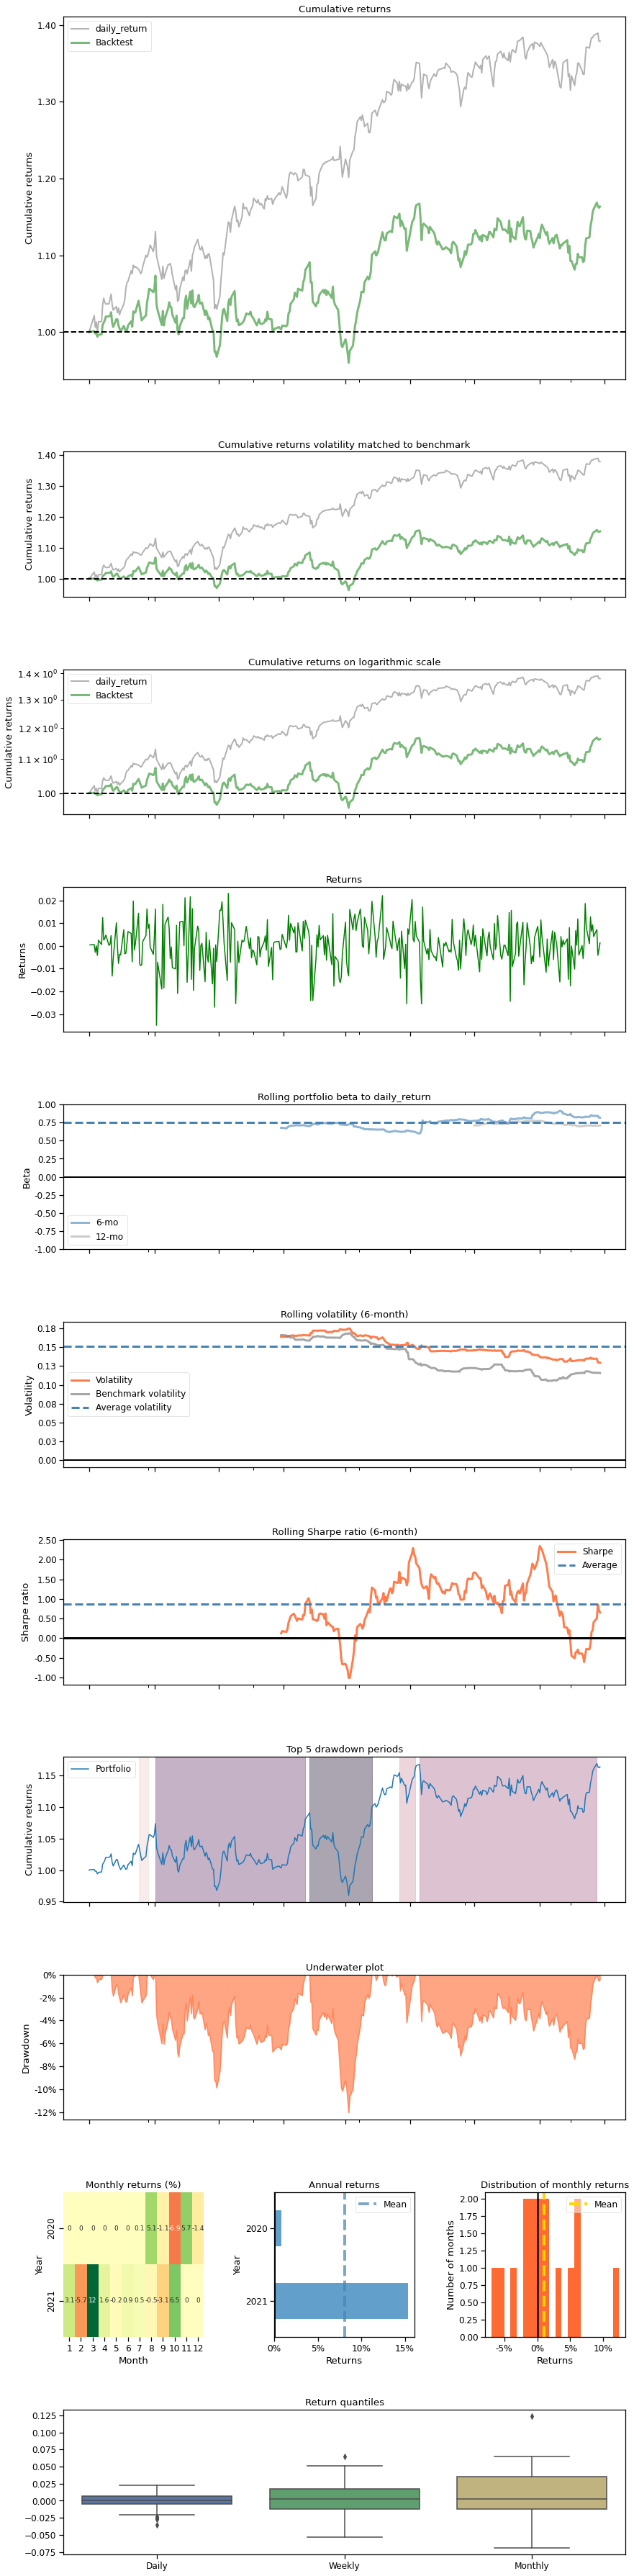

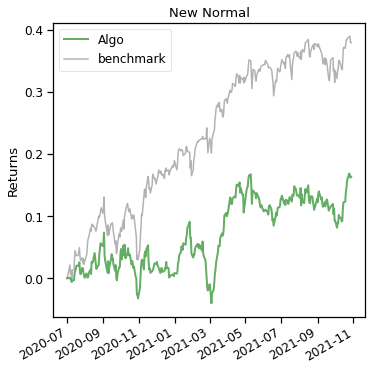

In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])